In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import theano.tensor as tt

In [2]:
x = np.linspace(0, 10, 50)

def exp_kernel(x, y, l):
    out = [np.exp(-((m-n)**2 / l**2)) for i,m in enumerate(x) for j,n in enumerate(y)]
    return np.reshape(out, (len(x), len(y)))

def brown_kernel(x, y, l):
    out = [np.exp(-(np.abs(m-n) / l**2)) for i,m in enumerate(x) for j,n in enumerate(y)]
    return np.reshape(out, (len(x), len(y)))

def periodic_kernel(x, y, t, l):
    """
    Periodic Kernel: T is the period and l is the length scale
    """
    out = [np.exp(-((2*np.sin(np.pi * np.abs(m-n) / t)**2) / l**2)) for i,m in enumerate(x) for j,n in enumerate(y)]
    return np.reshape(out, (len(x), len(y)))


# Draw Samples from the Prior

In [3]:
sigma = periodic_kernel(x, x, 2,1) * brown_kernel(x, x, 4)
mu = np.zeros(len(x))
sample = np.random.multivariate_normal(mu, sigma, size=5)
sample.shape

(5, 50)

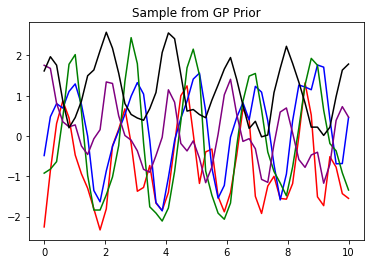

In [4]:
colors = ["red", "blue", "green", "purple", "black"]
for k, v in enumerate(colors):
    plt.plot(x, sample[k,:], color=v)
    plt.title("Sample from GP Prior")

# Fitting the GP to data

Given that $y_i \sim N(\mu, \sigma^2),\;i=1,...,n$, the GP Priors are convienent because they are conditinally conjugate so that the conditional posterior is also a Gaussian process with new $\mu$ and $\Sigma$. Given a GP Prior, $GP(0,k)$, the joint density for the observations and additional locations, $\hat{x}$ is:

$$\hat{\mu} \sim N(\mathbb{E}\left[\hat{\mu}\right], cov\left[\hat{\mu}\right])$$
where:

\begin{align*}
\mathbb{E}\left[\hat{\mu}\right] & = k(x, \hat{x})k(x,x)^{-1} y\\
cov\left[\hat{\mu}\right] & = k(\hat{x}, k(\hat{x}) - k(\hat{x}, x)k(x,x)^{-1}k(x,\hat{x})
\end{align*}



# Example

Given a set of points $(2,0), (4,1), (6, -1), (8,4)$ we can condition our priors using the above equations, and then take 50 samples from the multivariate normal posterior. I've defined the function "GP_cond" to accept any kernal you wish to include. Usually the choice of kernal is determined by some prior knowledge about the problem.


In [9]:
y = np.array([[2, 4, 6, 8], [0, 1, -1, 4]]).transpose()
sig = 0

def GP_cond(x, y, xhat, kernel, sig=0, l=1):
    """
    Calculates mean and covariance of the conditional GP. Expects x, y as column arrays
    """
    k_xx = kernel(x, x, l) + np.diag(np.zeros(len(y)) + sig)
    k_xxh = kernel(x, xhat, l)
    k_xhxh = kernel(xhat, xhat, l)
    k_xhx = kernel(xhat, x, l)

    mu = np.dot(np.dot(k_xhx, np.linalg.inv(k_xx)), y)
    cov = k_xhxh - np.dot(np.dot(k_xhx, np.linalg.inv(k_xx)),  k_xxh)

    return mu, cov

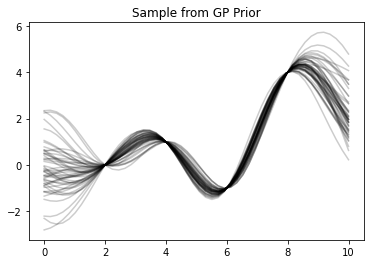

In [10]:
num_draws = 50
mu, sigma = GP_cond(y[:,0], y[:,1], x, exp_kernel, sig=0, l=2)
sample = np.random.multivariate_normal(mu, sigma, size=num_draws)

for k in range(num_draws):
    plt.plot(x, sample[k,:], color="black", alpha=.2)
    plt.title("Sample from GP Prior")

# Birthdays Example

Text(0, 0.5, 'Number of Births')

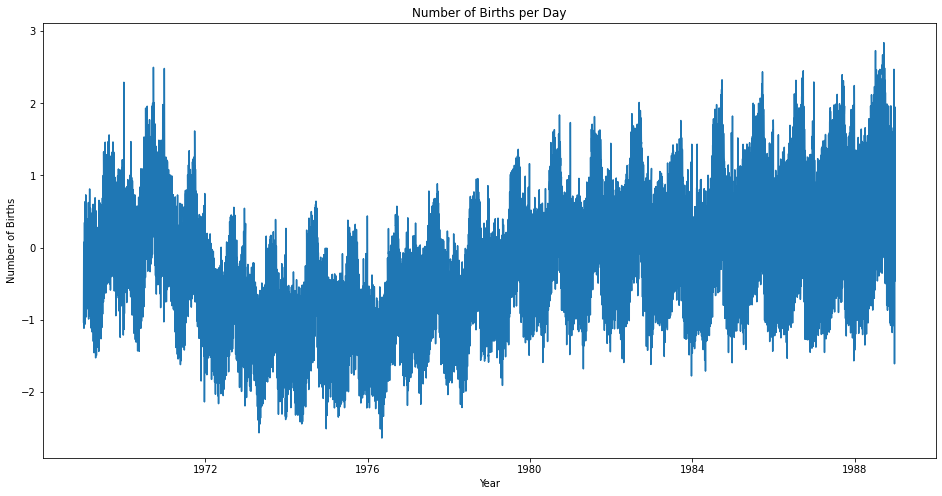

In [15]:
birthdays = pd.read_csv("./birthdays.txt")
birthdays["date"] = pd.to_datetime(birthdays[["year", "month", "day"]])
bd_mean = birthdays["births"].mean()
bd_sd = birthdays["births"].std()
birthdays["scaled_births"] = (birthdays["births"] - bd_mean) / bd_sd
plt.figure(figsize=(16,8))
plt.plot(birthdays.date, birthdays.scaled_births)
plt.title("Number of Births per Day")
plt.xlabel("Year")
plt.ylabel("Number of Births")

We can focus in on a single year. Here we simply filter the data down to 1976 and notice the weekly trend, and potential seasonal pattern. It's difficult to detrmin whether or not holiday effects are present given this representation. 

Text(0, 0.5, 'Number of Births')

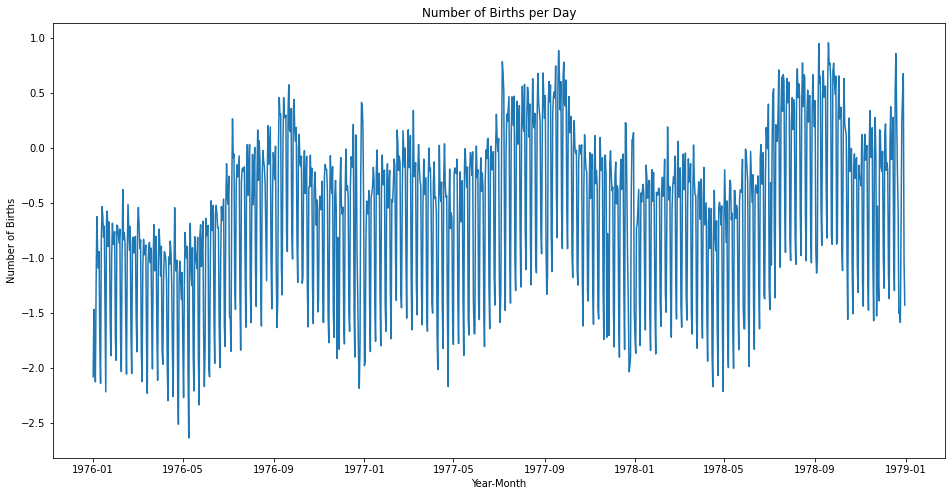

In [16]:
bd_1976 = birthdays.query("year >= 1976 and year < 1979")
plt.figure(figsize=(16,8))
plt.plot(bd_1976.date, bd_1976.scaled_births)
plt.title("Number of Births per Day")
plt.xlabel("Year-Month")
plt.ylabel("Number of Births")

In [17]:
with pm.Model() as model:
    # Our model will conisist of 5 GP's with differing cov functions to capture different traits of the data
    # Use squared exponential to model long term trend
    l_1 = pm.Uniform('l_1', 0, 10)
    sigma_1=pm.HalfCauchy('sigma_1', 10)
    cov_1 = sigma_1 * pm.gp.cov.ExpQuad(1, l_1)
    f_1 = pm.gp.Marginal(cov_func=cov_1)

    # Use squared exponential to model short term trend
    l_2 = pm.Uniform('l_2', 0, 10)
    sigma_2=pm.HalfCauchy('sigma_2', 10)
    cov_2 = sigma_2 * pm.gp.cov.ExpQuad(1, l_2)
    f_2 = pm.gp.Marginal(cov_func=cov_2)

    # Use squared exponential to model short term trend
    l_31 = pm.Uniform('l_31', 0, 10)
    l_32 = pm.Uniform('l_32', 0, 10)
    sigma_3=pm.HalfCauchy('sigma_3', 10)
    cov_3 = sigma_3 * pm.gp.cov.ExpQuad(1, l_31) * pm.gp.cov.Periodic(1,7,l_32)
    f_3 = pm.gp.Marginal(cov_func=cov_3)

    # Use squared exponential to model short term trend
    l_41 = pm.Uniform('l_41', 0, 10)
    l_42 = pm.Uniform('l_42', 0, 10)
    sigma_4=pm.HalfCauchy('sigma_4', 10)
    cov_4 = sigma_3 * pm.gp.cov.ExpQuad(1, l_41) * pm.gp.cov.Periodic(1,365.25,l_42)
    f_4 = pm.gp.Marginal(cov_func=cov_4)

    sigma = pm.HalfCauchy('sigma', 10)

    # covariance functions for the function f and the noise
    gp = f_1 + f_2 + f_3 + f_4
    y_ = gp.marginal_likelihood('y_obs',X=np.expand_dims(bd_1976.index.to_numpy(), axis=1), y=bd_1976["scaled_births"].values, noise=sigma)
    advi_fit = pm.fit(method='advi', n=4500, obj_optimizer=pm.adagrad(learning_rate=1e-1))
    #trace = pm.sample(2000)
    #y_obs = pm.gp.GP('y_obs', cov_func=f_cov, sigma=s2_n, observed={'X':, 'Y':y})

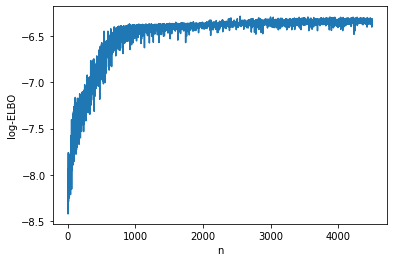

In [20]:
import seaborn as sns
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

In [21]:
num_samples = 2000
with model:
    trace = advi_fit.sample(num_samples)

In [22]:
theta = np.zeros(shape = (num_samples,len(trace.varnames)))
params = ["l_1", "sigma_1", "l_2", "sigma_2", "l_31", "l_32", "sigma_3", "l_41", "l_42", "sigma_4", "sigma"]
for i, varname in enumerate(trace.varnames):
    theta[:,i] = trace.get_values(varname)

params = pd.DataFrame(theta, columns=trace.varnames)[params].mean(axis=0)
print(params)


l_1         4.143286
sigma_1     0.018059
l_2         5.776358
sigma_2     0.017326
l_31        9.925986
l_32        0.442322
sigma_3     0.336350
l_41        9.782946
l_42        5.527578
sigma_4    27.484698
sigma       0.177952
dtype: float64


In [23]:
x = bd_1976.index.to_numpy()
k1 = 0.021403 * exp_kernel(x,x, 6.156395)
k2 = 0.020529 * exp_kernel(x,x,5.583693)
k3 = 0.340293 * exp_kernel(x,x,9.927571) * periodic_kernel(x,x,7,0.440758)
k4 = 29.462359 * exp_kernel(x,x,9.793686) * periodic_kernel(x,x,365.25,5.488513)
k_prime = k1+k2+k3+k4

In [59]:
#f1_mean = np.dot(np.dot(k1, np.linalg.inv(k_prime + np.diag(np.full(k_prime.shape[0],0.186163)))),bd_1976["scaled_births"].values)
f4_mean = k4 @ np.linalg.inv(k_prime) @ bd_1976["scaled_births"].values

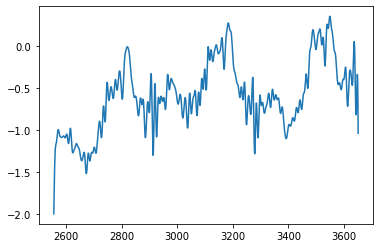

In [44]:
plt.plot(x, f4_mean) # this is without interaction terms

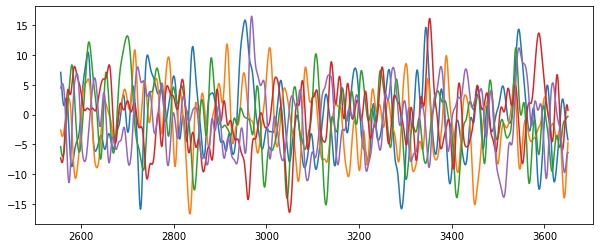

In [45]:
samples_f4 = np.random.multivariate_normal(mean = f4_mean, cov = k4, size=20)

fig, ax = plt.subplots(figsize=(10,4))
for i in range(5):
    plt.plot(x, samples_f4[i,:])

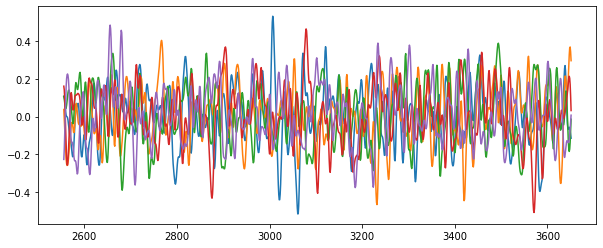

In [46]:
f2_mean = np.dot(np.dot(k2, np.linalg.inv(k_prime)),bd_1976["scaled_births"].values)
samples_f2 = np.random.multivariate_normal(mean = f2_mean, cov = k2, size=20)

fig, ax = plt.subplots(figsize=(10,4))
for i in range(5):
    plt.plot(x, samples_f2[i,:])

In [55]:
# plt.imshow(k_prime, cmap='hot', interpolation='nearest')
# plt.show()

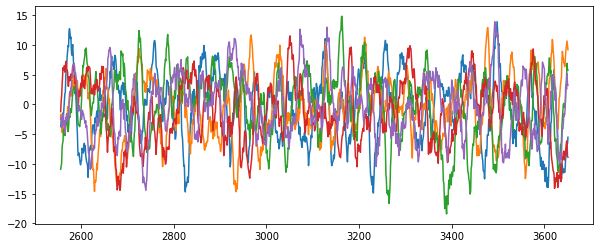

In [56]:
f1_mean = np.dot(np.dot(k1, np.linalg.inv(k_prime)),bd_1976["scaled_births"].values)
samples_f1 = np.random.multivariate_normal(mean = f1_mean, cov = k1, size=20)

f2_mean = np.dot(np.dot(k2, np.linalg.inv(k_prime)),bd_1976["scaled_births"].values)
samples_f2 = np.random.multivariate_normal(mean = f2_mean, cov = k2, size=20)

f3_mean = np.dot(np.dot(k3, np.linalg.inv(k_prime)),bd_1976["scaled_births"].values)
samples_f3 = np.random.multivariate_normal(mean = f3_mean, cov = k3, size=20)

f4_mean = np.dot(np.dot(k4, np.linalg.inv(k_prime)),bd_1976["scaled_births"].values)
samples_f4 = np.random.multivariate_normal(mean = f4_mean, cov = k4, size=20)

samples_tot = samples_f1 + samples_f2 + samples_f3 + samples_f4

fig, ax = plt.subplots(figsize=(10,4))
for i in range(5):
    plt.plot(x, samples_tot[i,:])

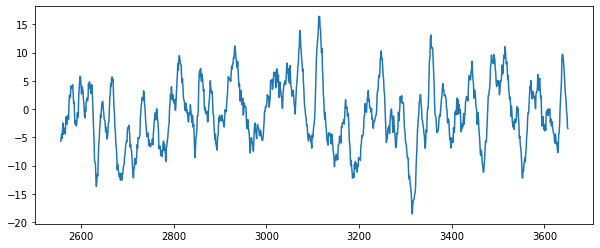

In [58]:
f_mean = np.dot(np.dot(k_prime, np.linalg.inv(k_prime)),bd_1976["scaled_births"].values)
samples_f = np.random.multivariate_normal(mean = f_mean, cov = k_prime, size=20)

fig, ax = plt.subplots(figsize=(10,4))
for i in range(1):
    plt.plot(x, samples_f[i,:])

In [18]:
#X_star = np.expand_dims(bd_1976.index.to_numpy(),axis=1)
with model:
# with model:
#     # conditional distributions of f1 and f2
#     f1_star = f_1.conditional("f1_star", X_star,
#                               given={"X": X, "y": y, "noise": sigma, "gp": gp})
#     # f2_star = f_2.conditional("f2_star", X_star,
#     #                           given={"X": X, "y": y, "noise": sigma, "gp": gp})
#     # f3_star = f_3.conditional("f2_star", X_star,
#     #                           given={"X": X, "y": y, "noise": sigma, "gp": gp})
#     # f4_star = f_4.conditional("f2_star", X_star,
#     #                           given={"X": X, "y": y, "noise": sigma, "gp": gp})

    f_star = gp.conditional("f_star", np.expand_dims(birthdays.index.to_numpy(), axis=1))
    samples = mp.sample(20)

In [ ]:
samples

In [12]:
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_star], samples=100)

In [ ]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_star"], np.expand_dims(bd_1976.index.to_numpy(),axis=1))
plt.plot(X, bd_1976["births"].values, "dodgerblue", lw=3, label="True f")


In [17]:
with model:
    mp.sample(20)

KeyError: "'f_star' not found"

In [ ]:
print("hi")